In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from autoencoder import *
from torch.optim import Adam
import json
from torchsummary import summary

# Load in Data Functions and Paths

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path
new_path = os.path.dirname(path)  # Remove the last folder

# Add the root directory (PARCTorch) to the system path
sys.path.append(new_path)
from data.normalization import compute_min_max

data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/Burgers/train",
    "/project/vil_baek/data/physics/PARCTorch/Burgers/test",
]
output_file = new_path + "/data/b_min_max.json"
compute_min_max(data_dirs, output_file)

from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/Burgers/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/Burgers/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(new_path, "data", "b_min_max.json")  # Correct path

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder
Total files to process: 478
Processed 100/478 files.
Processed 200/478 files.
Processed 300/478 files.
Processed 400/478 files.
Processed 478/478 files.
Channel-wise min values: [100.0, 3.029068460335956e-15, 3.029068460335956e-15]
Channel-wise max values: [15000.0, 1.4081184805131373, 1.4081184805131373]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/b_min_max.json'.


# Create Data Loader for Training

In [3]:
n_ts = 2
batch_size = 32
validation_split = 0.05  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
    vflip_prob=0.5,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-05-26 14:37:09,073 [INFO] Starting data validation...
2025-05-26 14:37:09,080 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:01<00:00, 92.97it/s]
2025-05-26 14:37:10,292 [INFO] Data validation completed successfully.
2025-05-26 14:37:10,295 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 365.67it/s]
2025-05-26 14:37:10,573 [INFO] Total samples in dataset: 10000


# Define Autoencoder Architecture + Training

In [ ]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder"
weights_name="burgers_3_6_6_6"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 6, 6]
latent_dim = 6
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.SiLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.SiLU()).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

#Loss Function
criterion = torch.nn.L1Loss().cuda()
# criterion = torch.nn.MSELoss().cuda()
# criterion = LpLoss(p=10).cuda()

# criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True)

#  training model
model = ConvolutionalAutoencoder(autoencoder, optimizer, device, save_path, weights_name)

log_dict = train_autoencoder(model.network, optimizer, criterion, train_loader, val_loader, 
                             device=device, epochs=100, image_size=[64, 64], n_channels=3, 
                             scheduler=scheduler, noise_fn=add_random_noise, initial_max_noise=0.16, reduce_on=10,
                             save_path=save_path, weights_name=weights_name)

/home/pdy2bw/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/100


Training:   0%|          | 0/297 [00:00<?, ?it/s]

# Load in weights

In [3]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 6, 6]
latent_dim = 6
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# training model
model = ConvolutionalAutoencoder(autoencoder, optimizer, device)

In [4]:
# load weights into model
weights_path = "burgers_layers_3_6_6_latent_6_nonoise_500.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_774102/2081185572.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(6, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Upsample(scale_factor=2.0, mode='bilinear')
      (7): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
    )
  )
)

In [5]:
summary(encoder, (3, 64, 64), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
            Conv2d-3            [-1, 6, 16, 16]             330
              ReLU-4            [-1, 6, 16, 16]               0
            Conv2d-5              [-1, 6, 8, 8]             330
Total params: 828
Trainable params: 828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


# Make Predictions

In [6]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-05-26 14:44:35,673 [INFO] Starting data validation...
2025-05-26 14:44:35,679 [INFO] Validating .npy files...
Validating files: 100%|██████████| 378/378 [00:02<00:00, 151.59it/s]
2025-05-26 14:44:38,179 [INFO] Data validation completed successfully.
2025-05-26 14:44:38,183 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 378/378 [00:02<00:00, 148.85it/s]
2025-05-26 14:44:40,725 [INFO] Total samples in dataset: 32886


In [7]:
sample_id = 0
ic, _, _, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
all_test_images = torch.concat((ic.unsqueeze(0), target))
print(all_test_images.shape)

torch.Size([3, 64, 64]) torch.Size([14, 3, 64, 64])
torch.Size([15, 3, 64, 64])


In [8]:
# Initialize list to store all reconstructed images
all_reconstructed_images = []

for i in range(n_ts):
    with torch.no_grad():
        img = all_test_images[i, ...].unsqueeze(0).to(device)  # Move image to same device
        reconstructed_img = model.network(img)
    all_reconstructed_images.append(reconstructed_img.cpu())  # move output back to CPU

# Concatenate all batches to create single tensors
all_reconstructed_images = torch.cat(all_reconstructed_images, dim=0)

In [9]:
all_test_images.shape, all_reconstructed_images.shape

(torch.Size([15, 3, 64, 64]), torch.Size([15, 3, 64, 64]))

# Visualizations

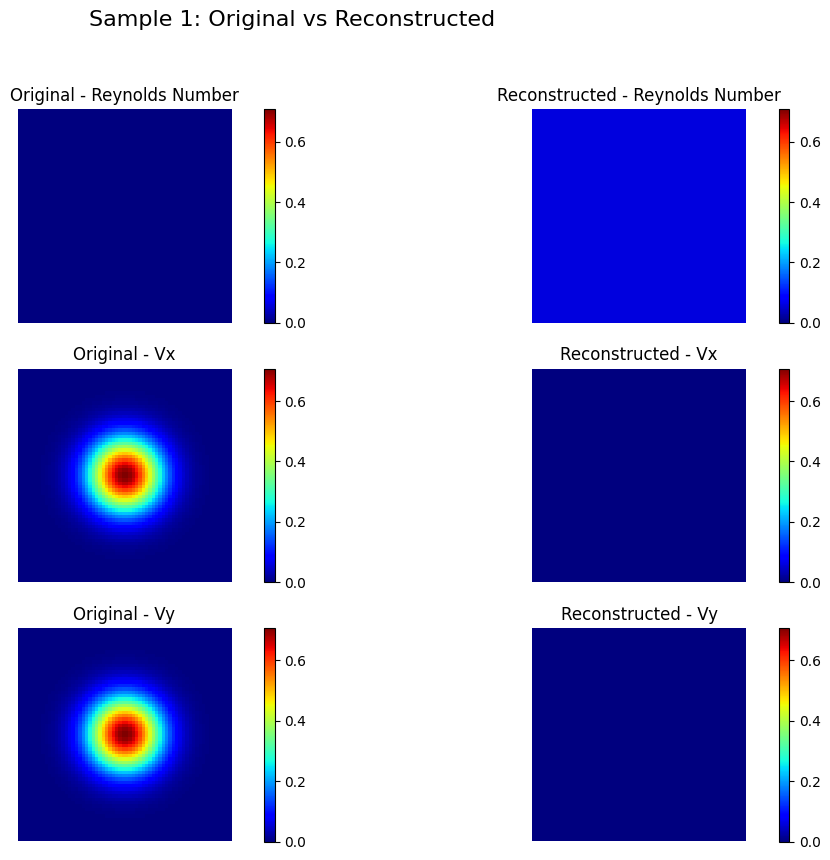

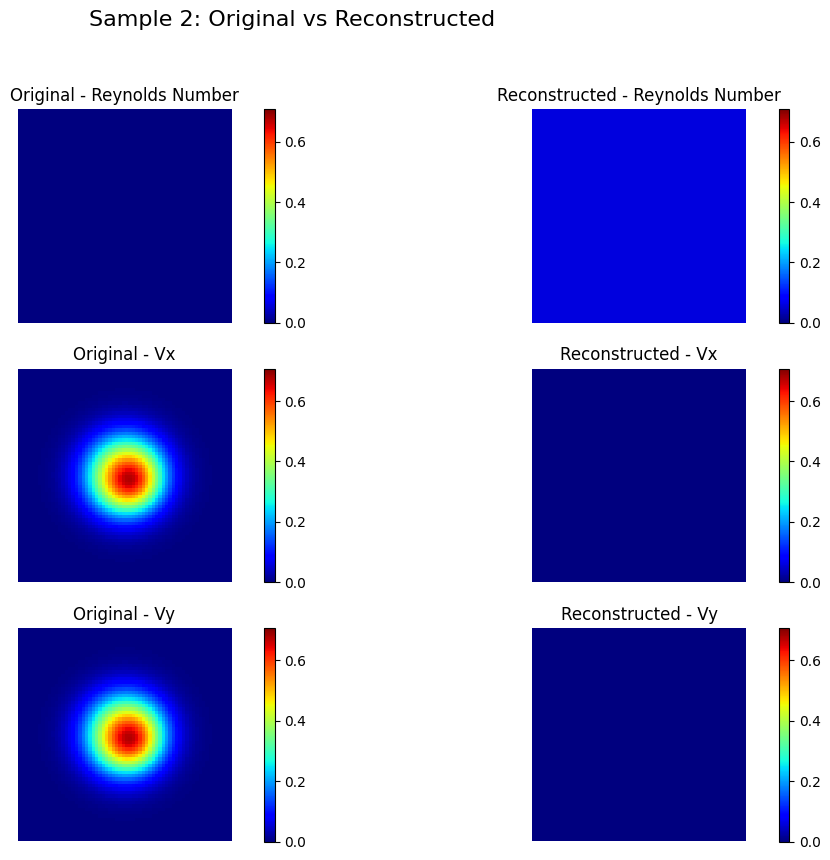

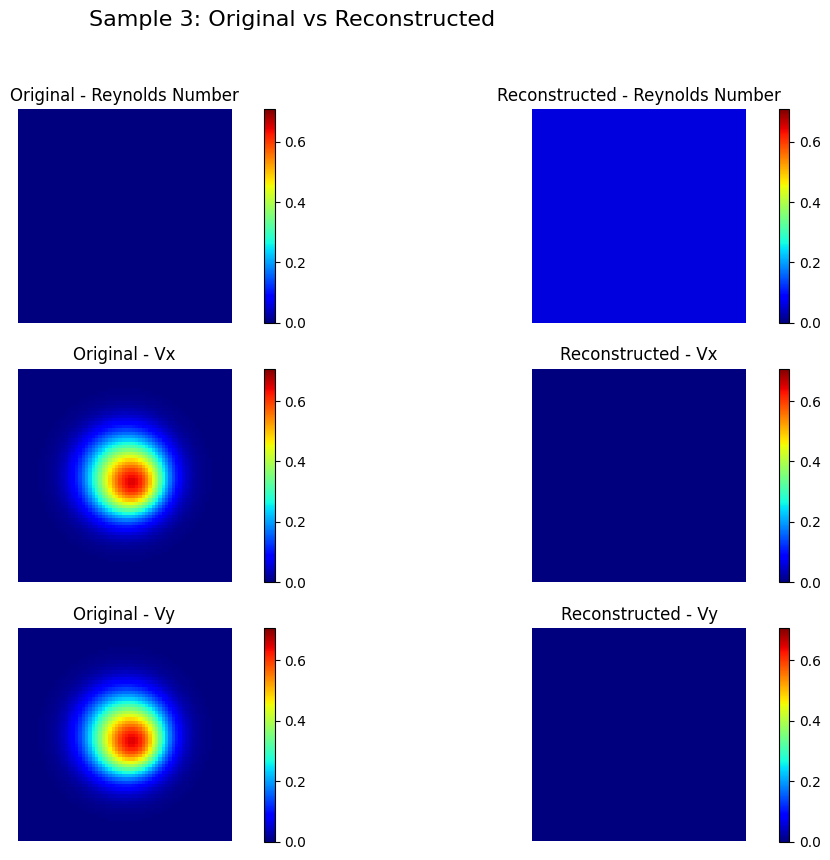

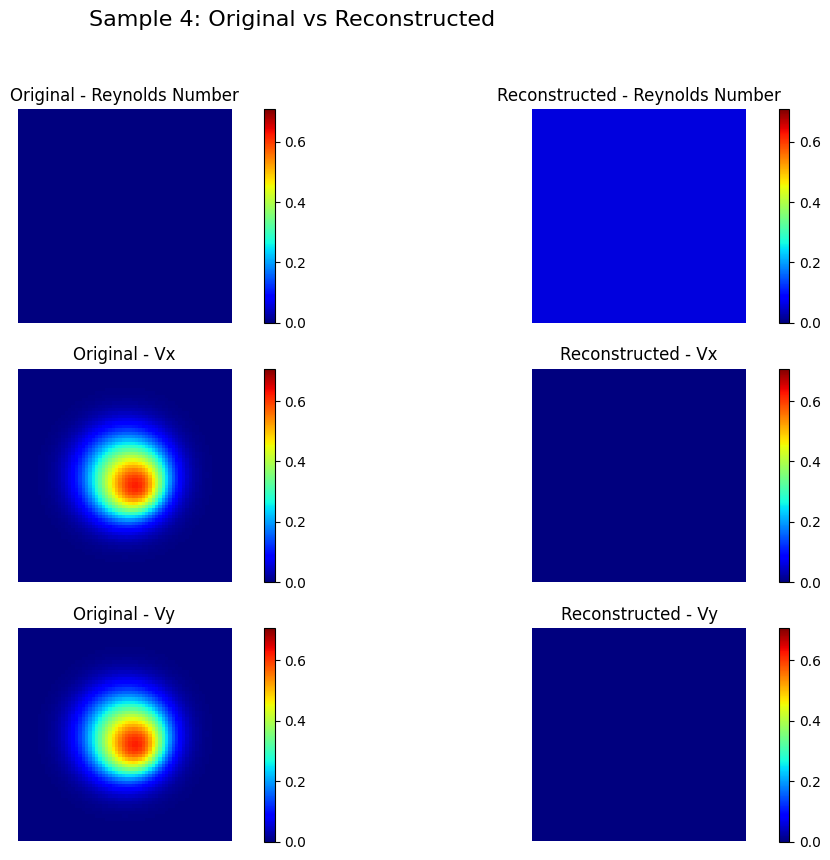

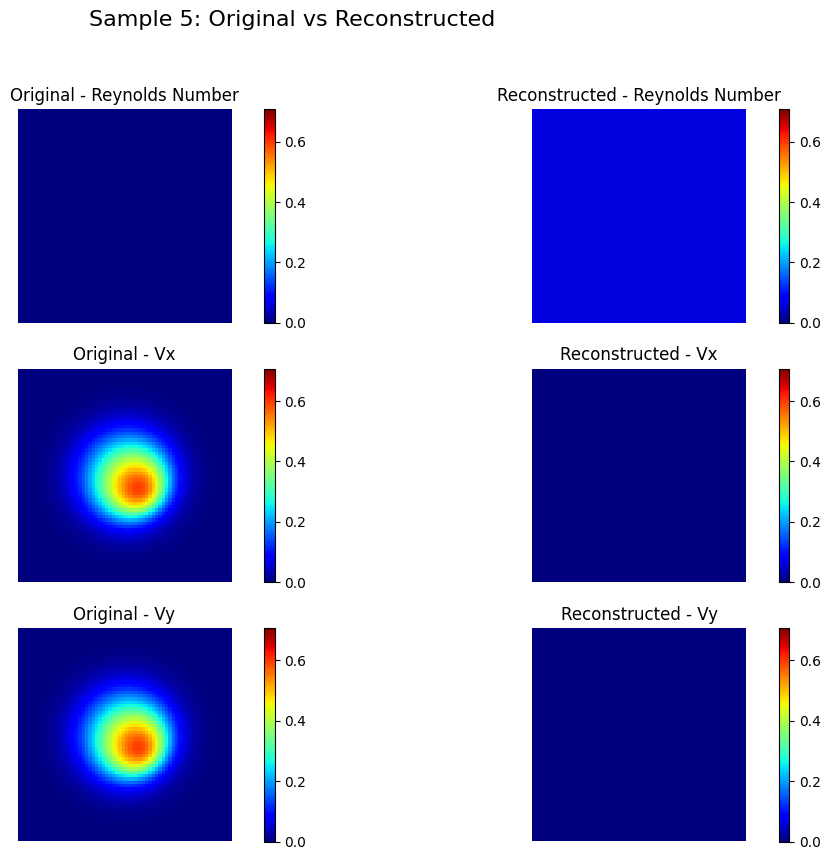

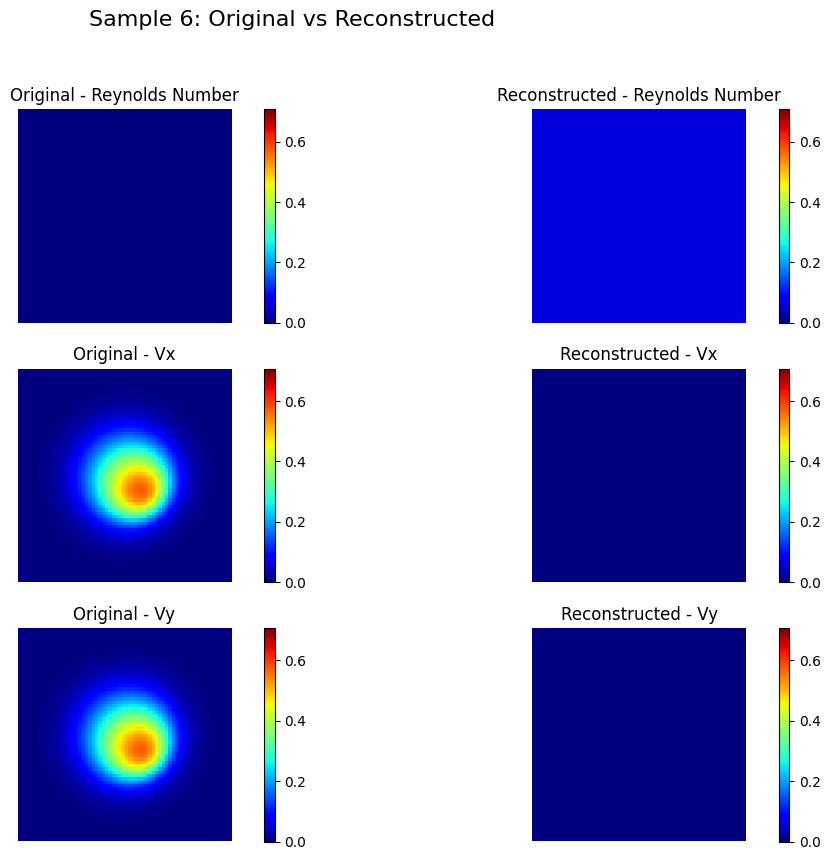

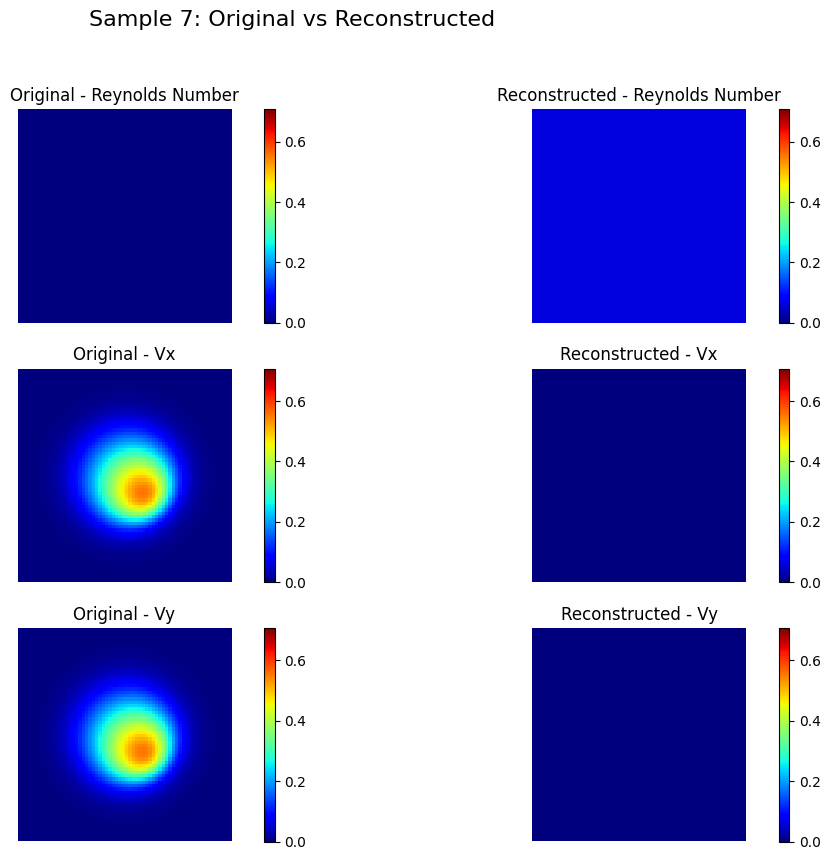

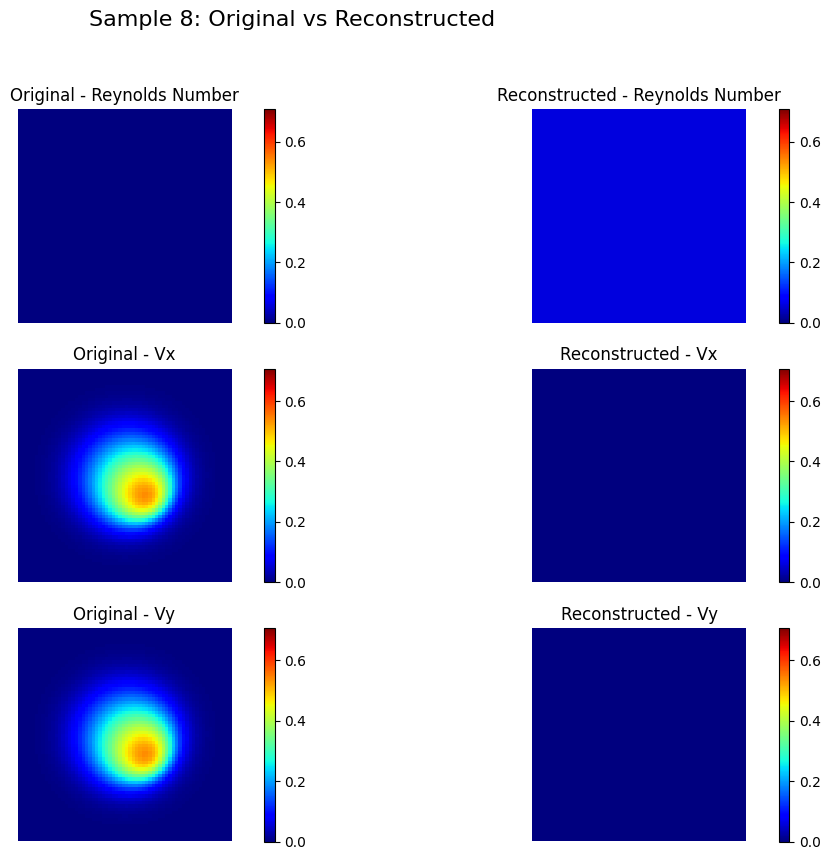

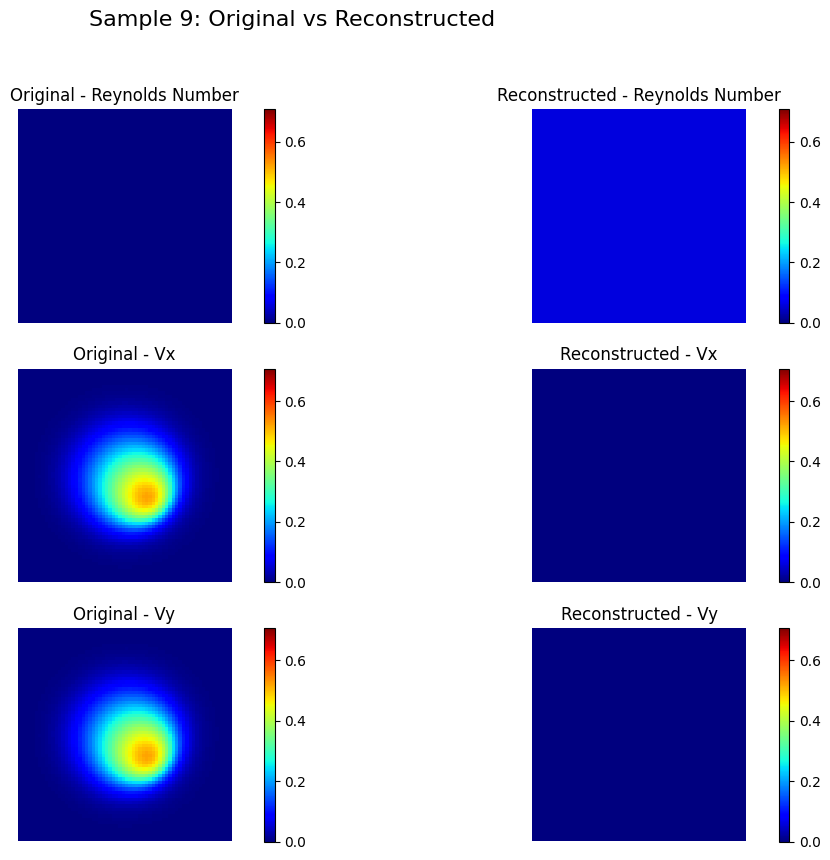

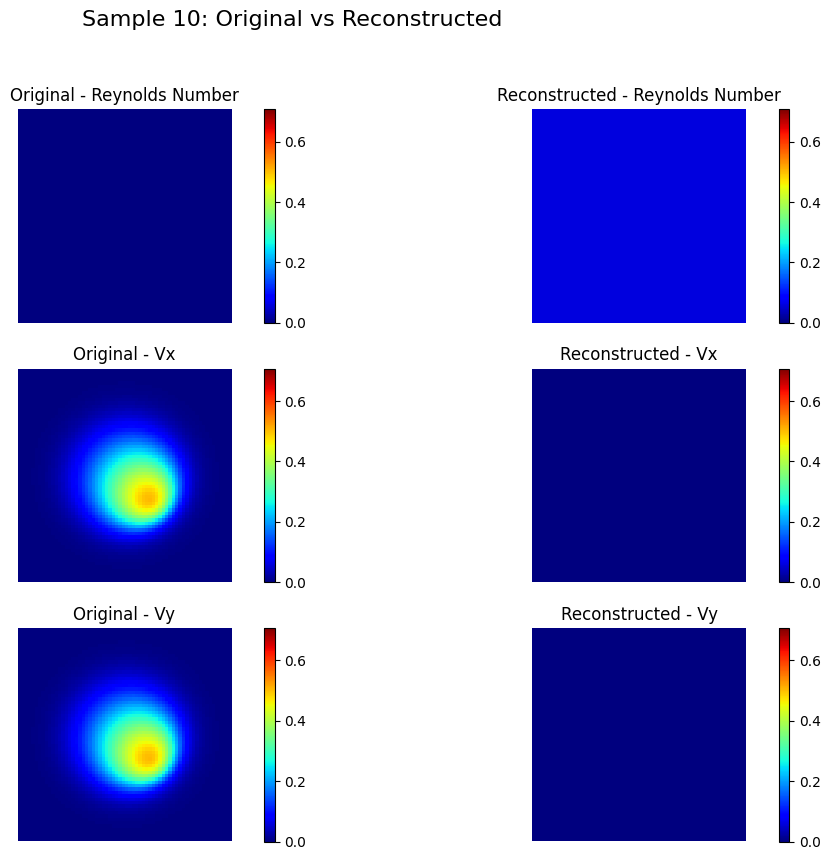

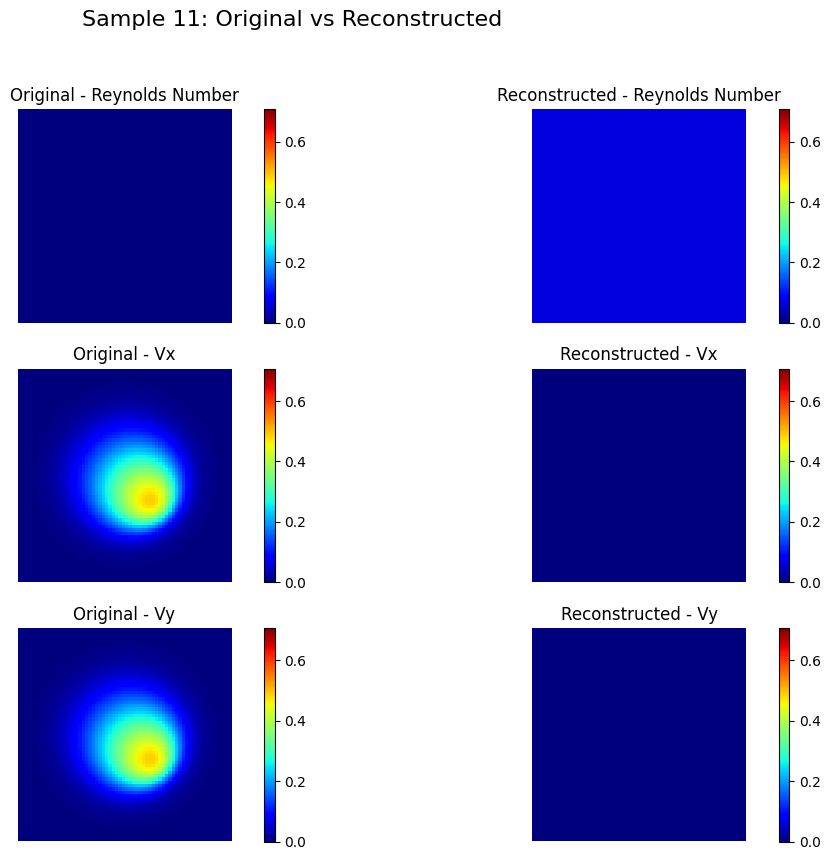

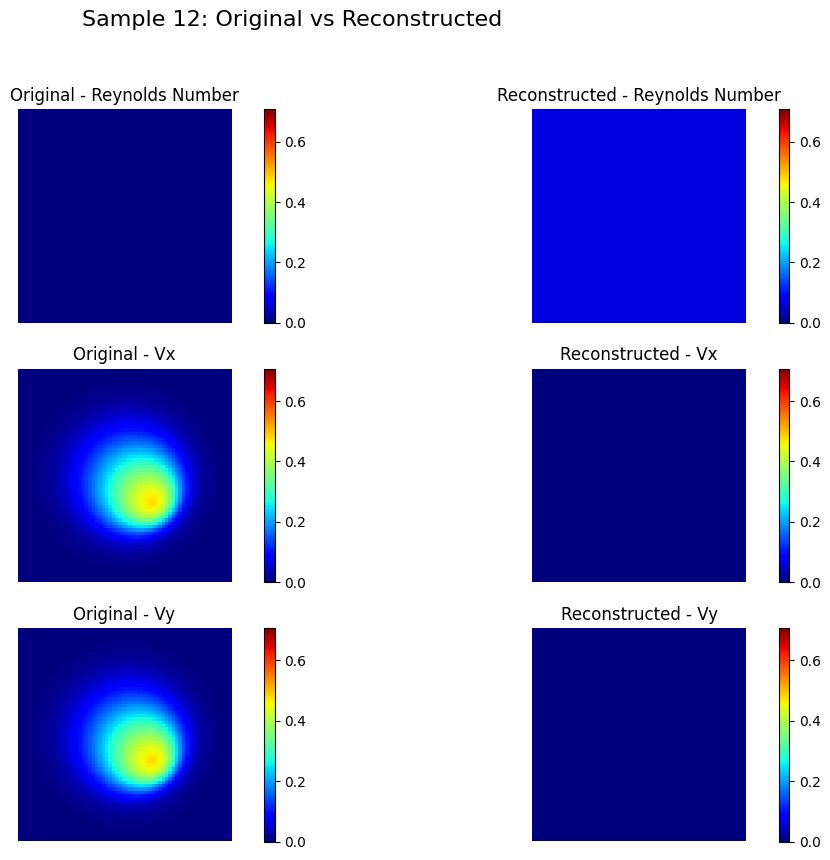

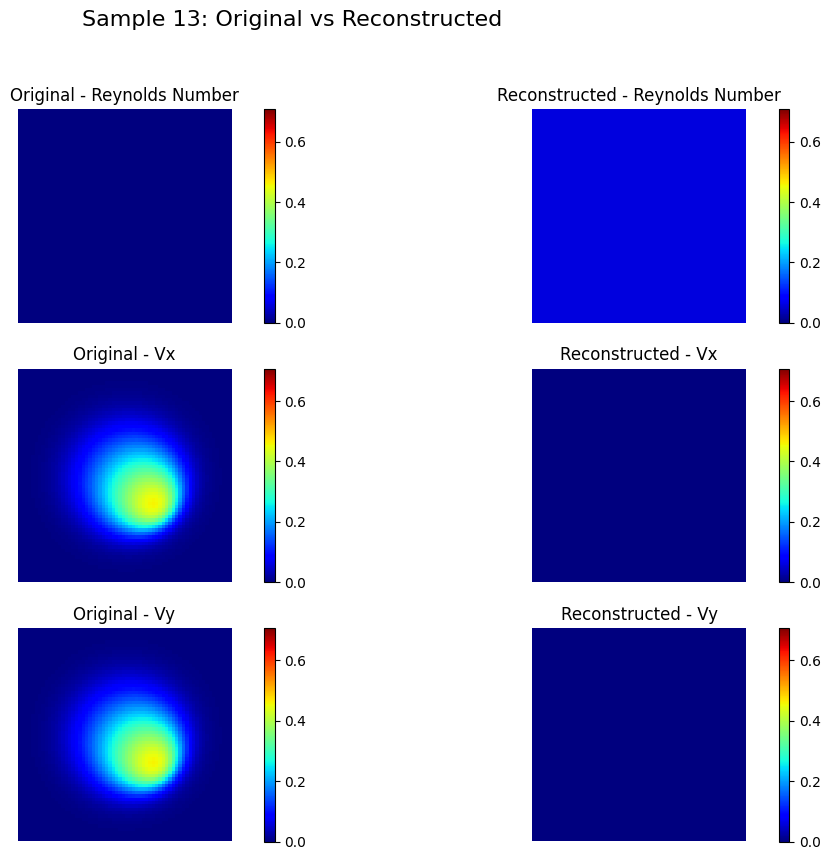

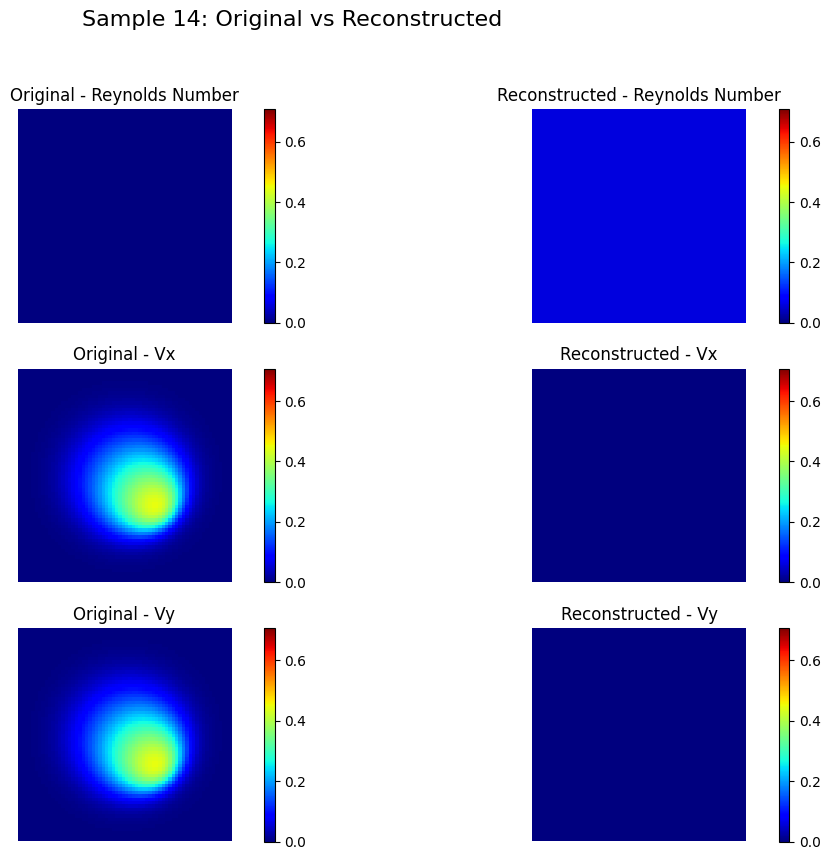

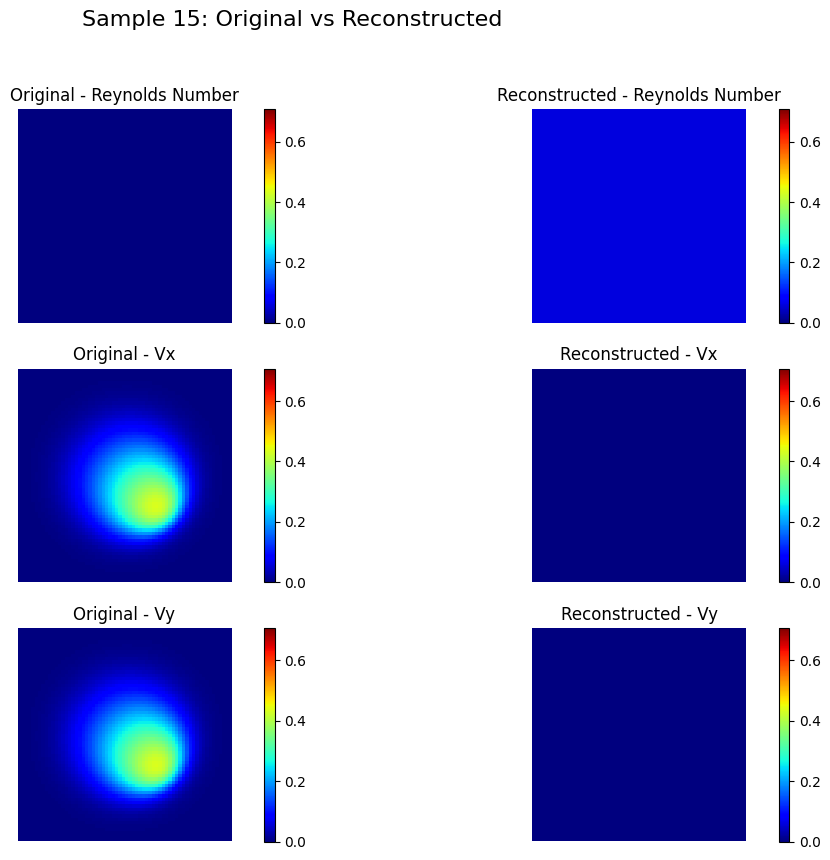

In [10]:
# Channel names for clarity
channel_names = ["Reynolds Number", "Vx", "Vy"]

num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()


## GIFs

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

file_name = "burgers_layers_3_6_6_latent_6_nonoise_500"
plot_name = "AE Prediction, No Dynamics, 500 Epochs"

# Channel names for clarity
channel_names = ["Reynolds Number", "Vx", "Vy"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_774102/1200461351.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to burgers_layers_3_6_6_latent_6_nonoise_500.gif


IndexError: index 6 is out of bounds for dimension 0 with size 6

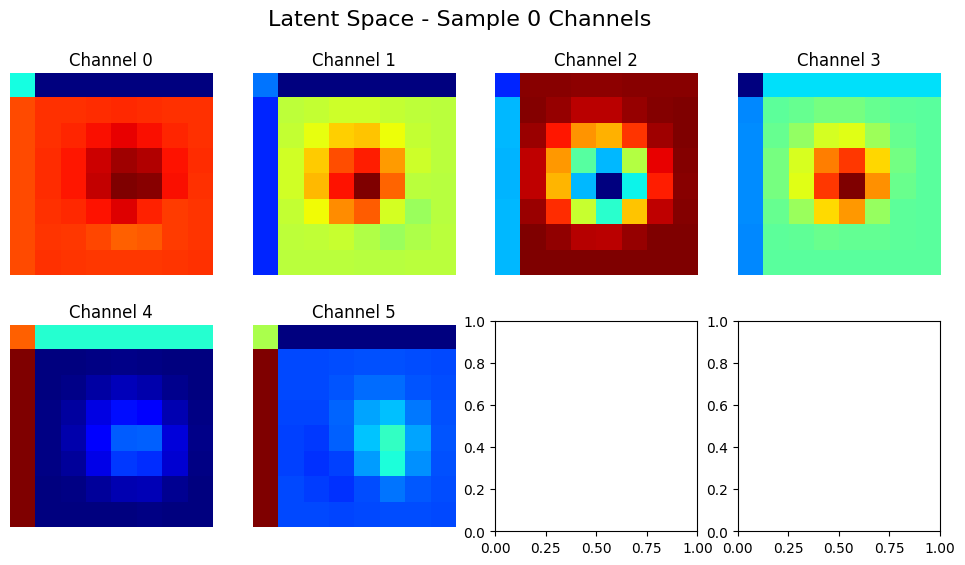

In [12]:
ts_idx = 6 # pick which time step you want to visualize

latent = model.network.encoder(all_test_images[ts_idx, ...].to(device))

latent.size()

n_channels = latent.shape[0]
n_rows, n_cols = 2, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
fig.suptitle('Latent Space - Sample 0 Channels', fontsize=16)

for ch, ax in enumerate(axes.flat):
    img = latent[ch].detach().cpu().numpy()  # shape: [32, 64]
    im = ax.imshow(img, cmap='jet')
    ax.set_title(f'Channel {ch}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Loss Plots

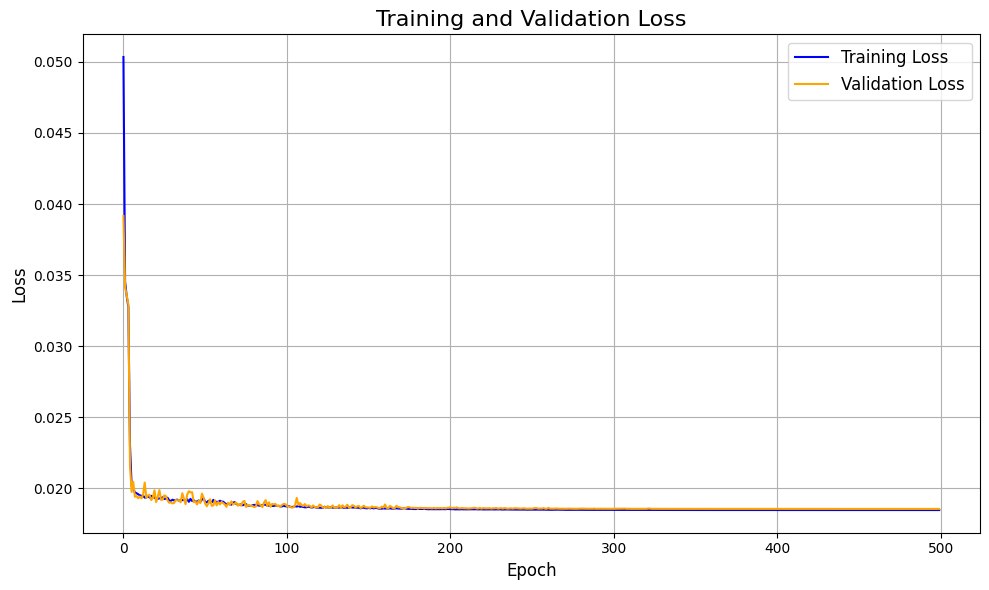

In [13]:
# Path to the JSON log file
log_file_path = "burgers_layers_3_6_6_latent_6_nonoise_500.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


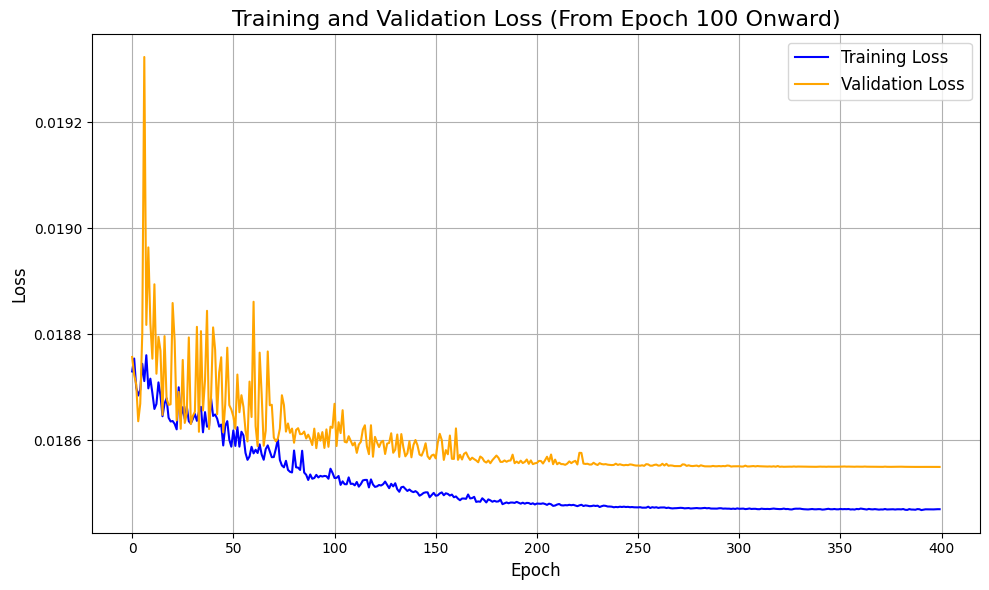

In [14]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 100

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Training and Validation Loss (From Epoch {start_epoch} Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
